In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [2]:
seed = 42

In [3]:
def isotropic_gaussian(n_samples, n_features,):

    mean = np.zeros(n_features)
    cov = np.zeros(shape=(n_features,n_features))
    np.fill_diagonal(cov, 1)

    return np.random.multivariate_normal(mean, cov,size=n_samples)

In [4]:
def scatter_helper(ax, xs, ys, zs=None, class_label = None):

    if zs is not None:
        if class_label is not None:
            sc = ax.scatter(xs, ys, zs, c=class_label, cmap='tab10', s=10)
        else:
            sc = ax.scatter(xs, ys, zs, s=10)
        return sc

    else:
        if class_label is not None:
            sc = ax.scatter(xs, ys, c=class_label, cmap='tab10', s=10)
        else:
            sc = ax.scatter(xs, ys, s=10)
        return sc
    
    return None

def plot_3d_scatters(X,title_name,y=None):

    fig, axs = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={})

    axs[0] = fig.add_subplot(1, 4, 1, projection='3d')
    xs,ys,zs = X[:, 0], X[:, 1], X[:, 2]
    scatter_helper(axs[0],xs,ys,zs,y)
    axs[0].set_title(title_name)

    # 2D scatter plots
    scatter_helper(axs[1],xs,ys,None,y)
    axs[1].set_title('0 vs 1')

    scatter_helper(axs[2],ys,zs,None,y)
    axs[2].set_title('1 vs 2')

    scatter_helper(axs[3],xs,zs,None,y)
    axs[3].set_title('0 vs 2')
        
    # plt.xlim(-2.5, 2.5)
    # plt.ylim(-2.5, 2.5)

    plt.tight_layout()
    plt.show()


In [5]:
# X.shape[1]

In [6]:
from scipy.spatial.distance import cdist

In [7]:
lst_metrics = [
    'braycurtis', 'canberra', 'chebyshev', 
    'cityblock', 'correlation', 'cosine', 'dice', 
    'euclidean', 'hamming', 'jaccard', 'jensenshannon', 
    'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 
    'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'
]

In [8]:
## PROBABLY REALLY BAD DESIGN: because point can be both str and float
# hacky for now but fix this / find a better way
def get_center_from_point(X,point=None):

    if point==None:
        return np.zeros(shape=(1,X.shape[1]))
    
    elif point=='global_mean_centroid':
        return np.mean(X,axis=0).reshape((1,X.shape[1]))
    
    elif point=='global_median_centroid':
        return np.median(X,axis=0).reshape((1,X.shape[1]))
    
    else:
        return point


In [9]:
def dist_from_point(X,point=None,metric='euclidean'):
    n_feat = X.shape[1]

    center = get_center_from_point(X,point)

    if metric.startswith('minkowski'):
        metricval = metric.split(' ')[0]
        pval = float(metric.split(' ')[1])
        return cdist(XA=X,XB=center,metric=metricval,p=pval)
    
    return cdist(XA=X,XB=center,metric=metric)

In [10]:
from sklearn.metrics import pairwise as sklearn_pairwise

In [11]:
def kernel_from_point(X,point=None,kernel_fn='linear'):

    ## FOR POSITIVE-- CONSIDER MASS IN SHELL OR SUMMING UP TO THE RADIUS?

    n_feat = X.shape[1]

    center = get_center_from_point(X,point)

    return sklearn_pairwise.kernel_metrics()[kernel_fn](X=X,Y=center)

In [12]:
# np.mean(X,axis=0).shape

In [13]:
n_samples = 1000
n_features = 3

In [14]:
X = isotropic_gaussian(n_samples, n_features)
# plot_3d_scatters(X,'iso_gauss')

In [15]:
# ellips_homosk_clusters = make_heteroskedastic_anisotropic_blobs_nd(n_samples=n_samples,n_features=n_features,cluster_std=[1.0,1.0,1.0])

In [16]:
# plot_3d_scatters(ellips_homosk_clusters[0],'')

In [17]:
from sklearn import cluster, datasets, mixture

gaus_homosk_blobs = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed)

gaus_heterosk_blobs = datasets.make_blobs(
    n_samples=n_samples,n_features=n_features, cluster_std=[1.0, 2.5, 0.5], random_state=seed
)

In [18]:
# plot_3d_scatters(gaus_homosk_blobs[0],'gauss_blobs')

In [19]:
# plot_3d_scatters(gaus_heterosk_blobs[0],'gauss_blobs')

## plotting distance distributions

In [20]:
from scipy.stats import iqr

In [21]:
# Define scaling functions with safety checks
def zscore_scale(dist):
    std = np.std(dist)
    if std == 0:
        raise ValueError("Standard deviation is zero — cannot z-score.")
    
    plot_dist = (dist - np.mean(dist)) / std
    
    return plot_dist

def iqr_scale(dist):
    iqr_val = iqr(dist)
    if iqr_val == 0:
        raise ValueError("IQR is zero — cannot robust scale.")

    plot_dist = (dist - np.median(dist)) / iqr_val

    return plot_dist

def minmax_scale(dist):
    min_val, max_val = np.min(dist), np.max(dist)
    if max_val - min_val == 0:
        raise ValueError("Range is zero — cannot min-max scale.")
    
    plot_dist = (dist - min_val) / (max_val - min_val)
    
    return plot_dist


In [22]:
def check_metric_plot(metric,plot_dist):
    if np.any(np.isnan(plot_dist)):
        raise ValueError(f'{metric} produced NaNs — cannot plot.')
    return plot_dist

In [23]:
def plot_dist_distribution(X,point=None,dist_scale='none',plot_type='violin'):

    # lst_metrics = [
    #     'braycurtis', 'canberra', 'chebyshev', 
    #     'cityblock', 'correlation', 'cosine', 
    #     'euclidean','mahalanobis', 
    #     'minkowski 0.25',  'seuclidean', 'sqeuclidean'
    # ]

    lst_metrics = [
        'canberra', 'chebyshev', 
        'cityblock', 'correlation', 'cosine', 
        'euclidean','mahalanobis', 
        'minkowski 0.25',  'seuclidean', 'sqeuclidean',
        'minkowski 4.0'
    ]

    nr = 2
    nc = 6
    fig, axes = plt.subplots(nr, nc, figsize=(5*nc, 5*nr)) 
    axes = axes.flatten()  # Flatten to 1D array for easy indexing


    no_fn = lambda dist : dist
    dist_scale_dict = {'zscore' : zscore_scale, 'iqr' : iqr_scale, 'minmax' : minmax_scale, 'none' : no_fn}

    metric_plot_dict = {}
    max_count = 0

    for metric in lst_metrics:

        dist_from_center = dist_from_point(X,point=point,metric=metric)        

        if dist_scale in dist_scale_dict.keys():
            try:
                plot_dist = dist_scale_dict[dist_scale](dist_from_center)
                plot_dist = check_metric_plot(metric,plot_dist)

            except Exception as e:
                plot_dist = None
                print(f"{metric} skipped: {e}")

        if plot_dist is not None:
            metric_plot_dict[metric] = plot_dist
            counts, _ = np.histogram(plot_dist)
            max_count = max(max_count, counts.max())            
            # max_count = max(max_count, plot_dist.max())

    for i,metric in enumerate(metric_plot_dict.keys()):        
        ax = axes[i]
        dist_vals = metric_plot_dict[metric]
        dist_vals = dist_vals[~np.isnan(dist_vals)]

        if plot_type=='violin':
            sns.violinplot(y=dist_vals, ax=ax, inner='quartile', cut=0)

        if plot_type=='hist':
            ax.hist(dist_vals)
            ax.set_ylim(0, max_count * 1.05)

        ax.set_title(metric) 

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()    
    # return metric_plot_dict

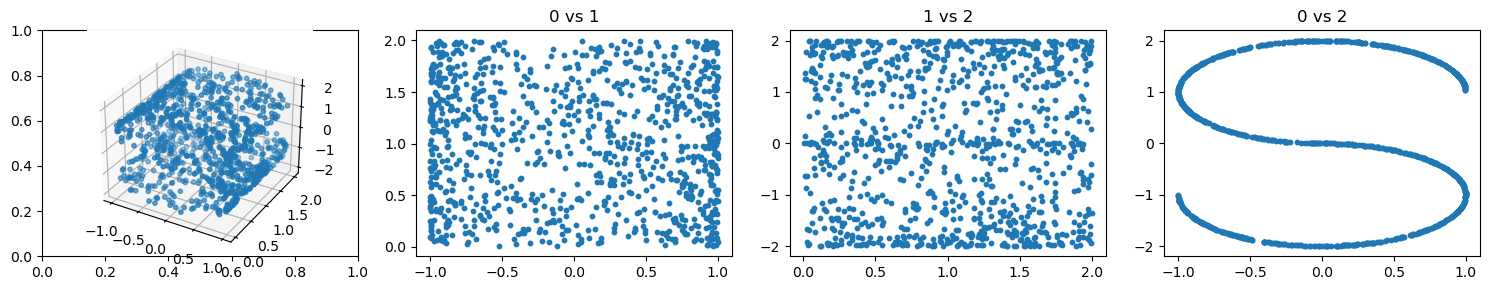

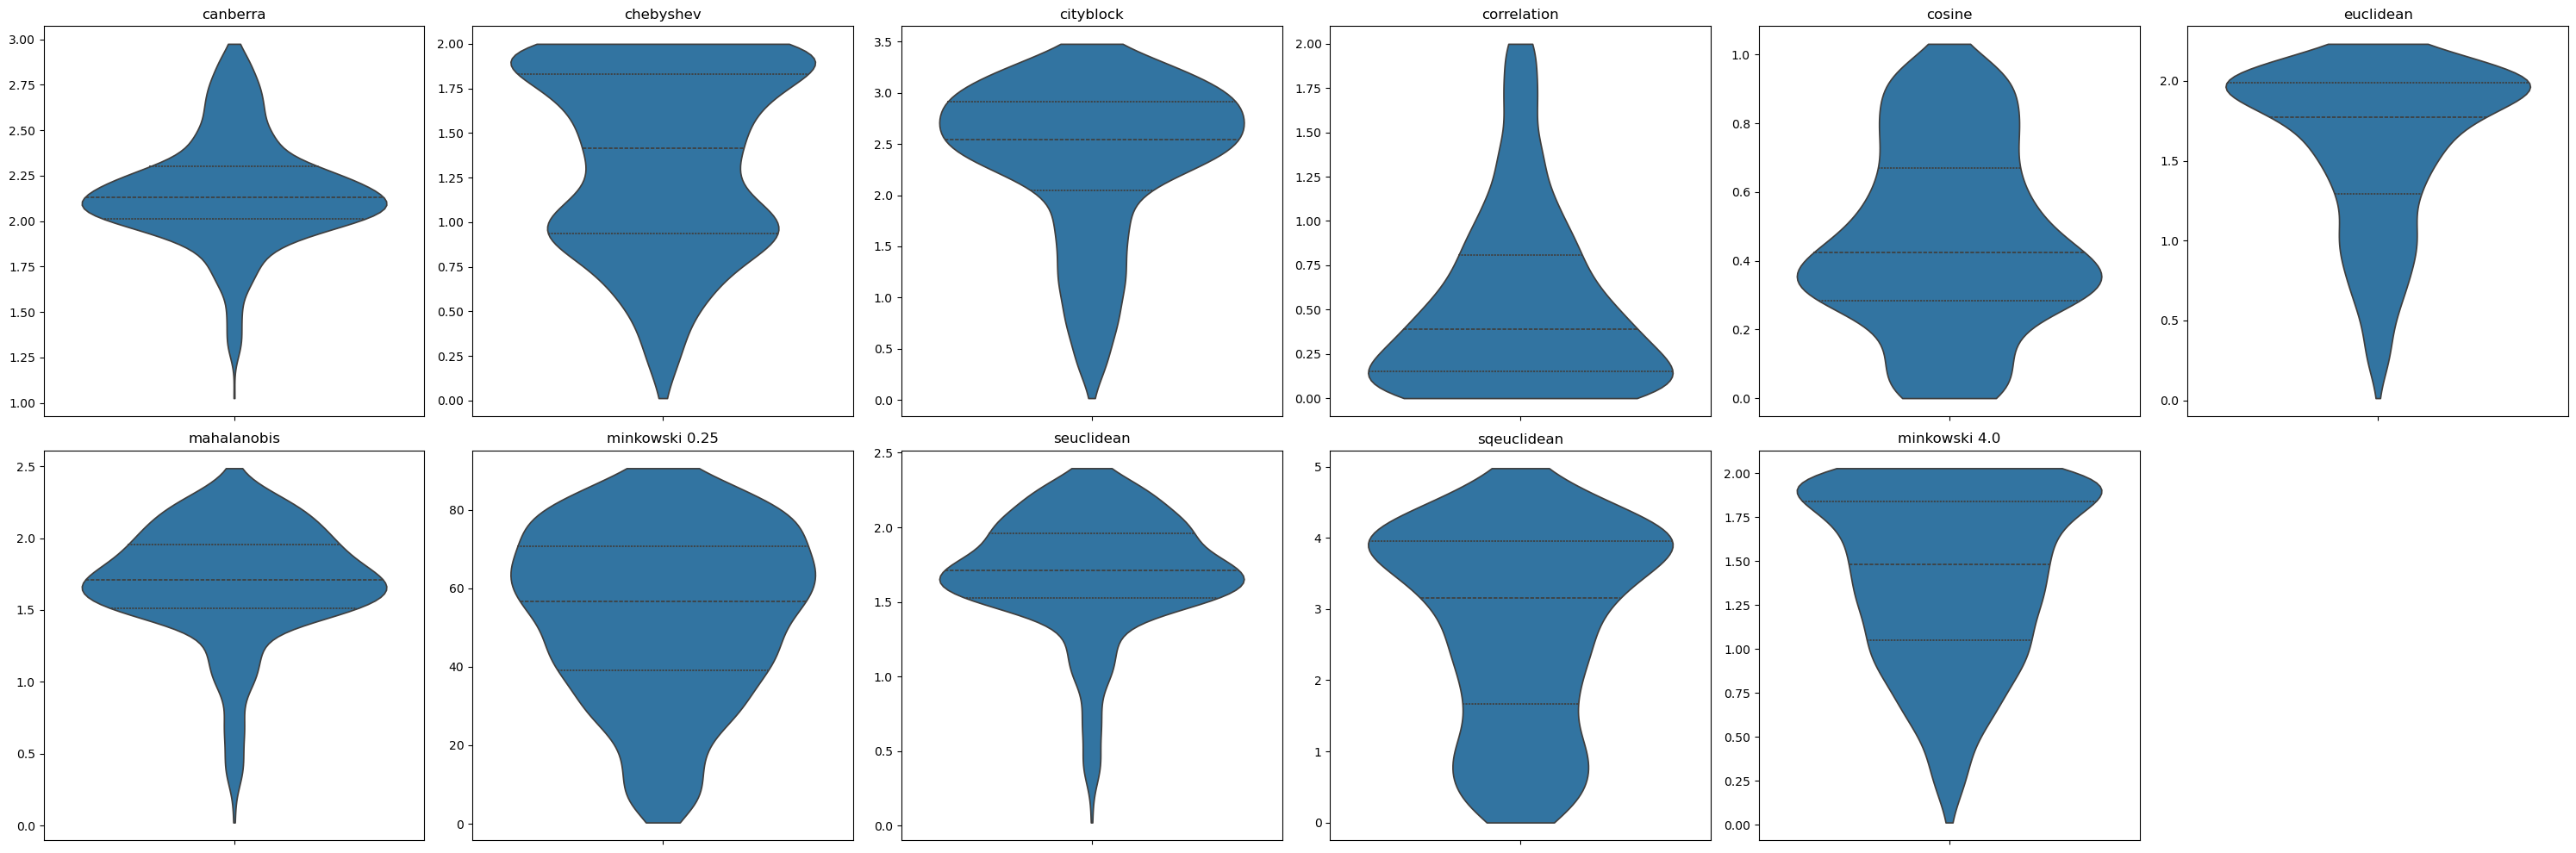

In [43]:
S_points, S_color = datasets.make_s_curve(n_samples, random_state=seed)

plot_3d_scatters(S_points,'')
plot_dist_distribution(S_points,point='global_median_centroid',dist_scale='none')

In [25]:
# swissrolldata = datasets.make_swiss_roll(
#     n_samples=n_samples,random_state=seed,noise=0.2
# )

# plot_3d_scatters(swissrolldata[0],'')
# plot_dist_distribution(swissrolldata[0],point='global_median_centroid',dist_scale='iqr')

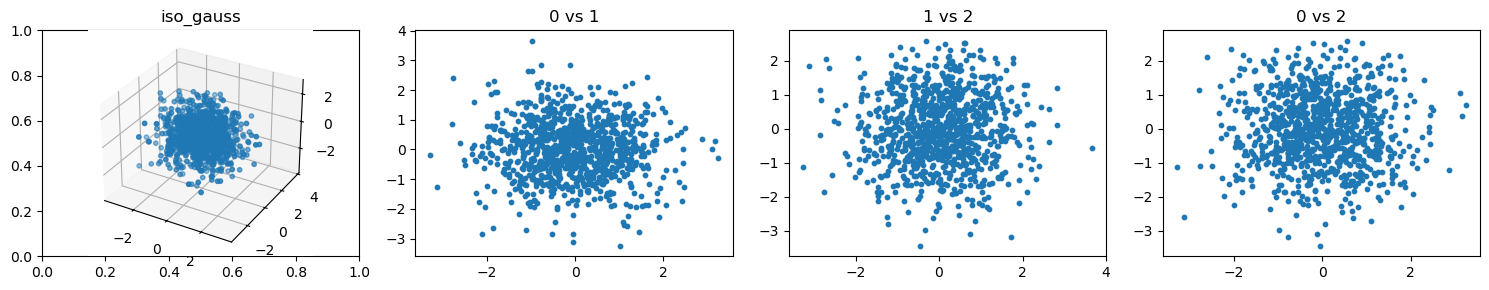

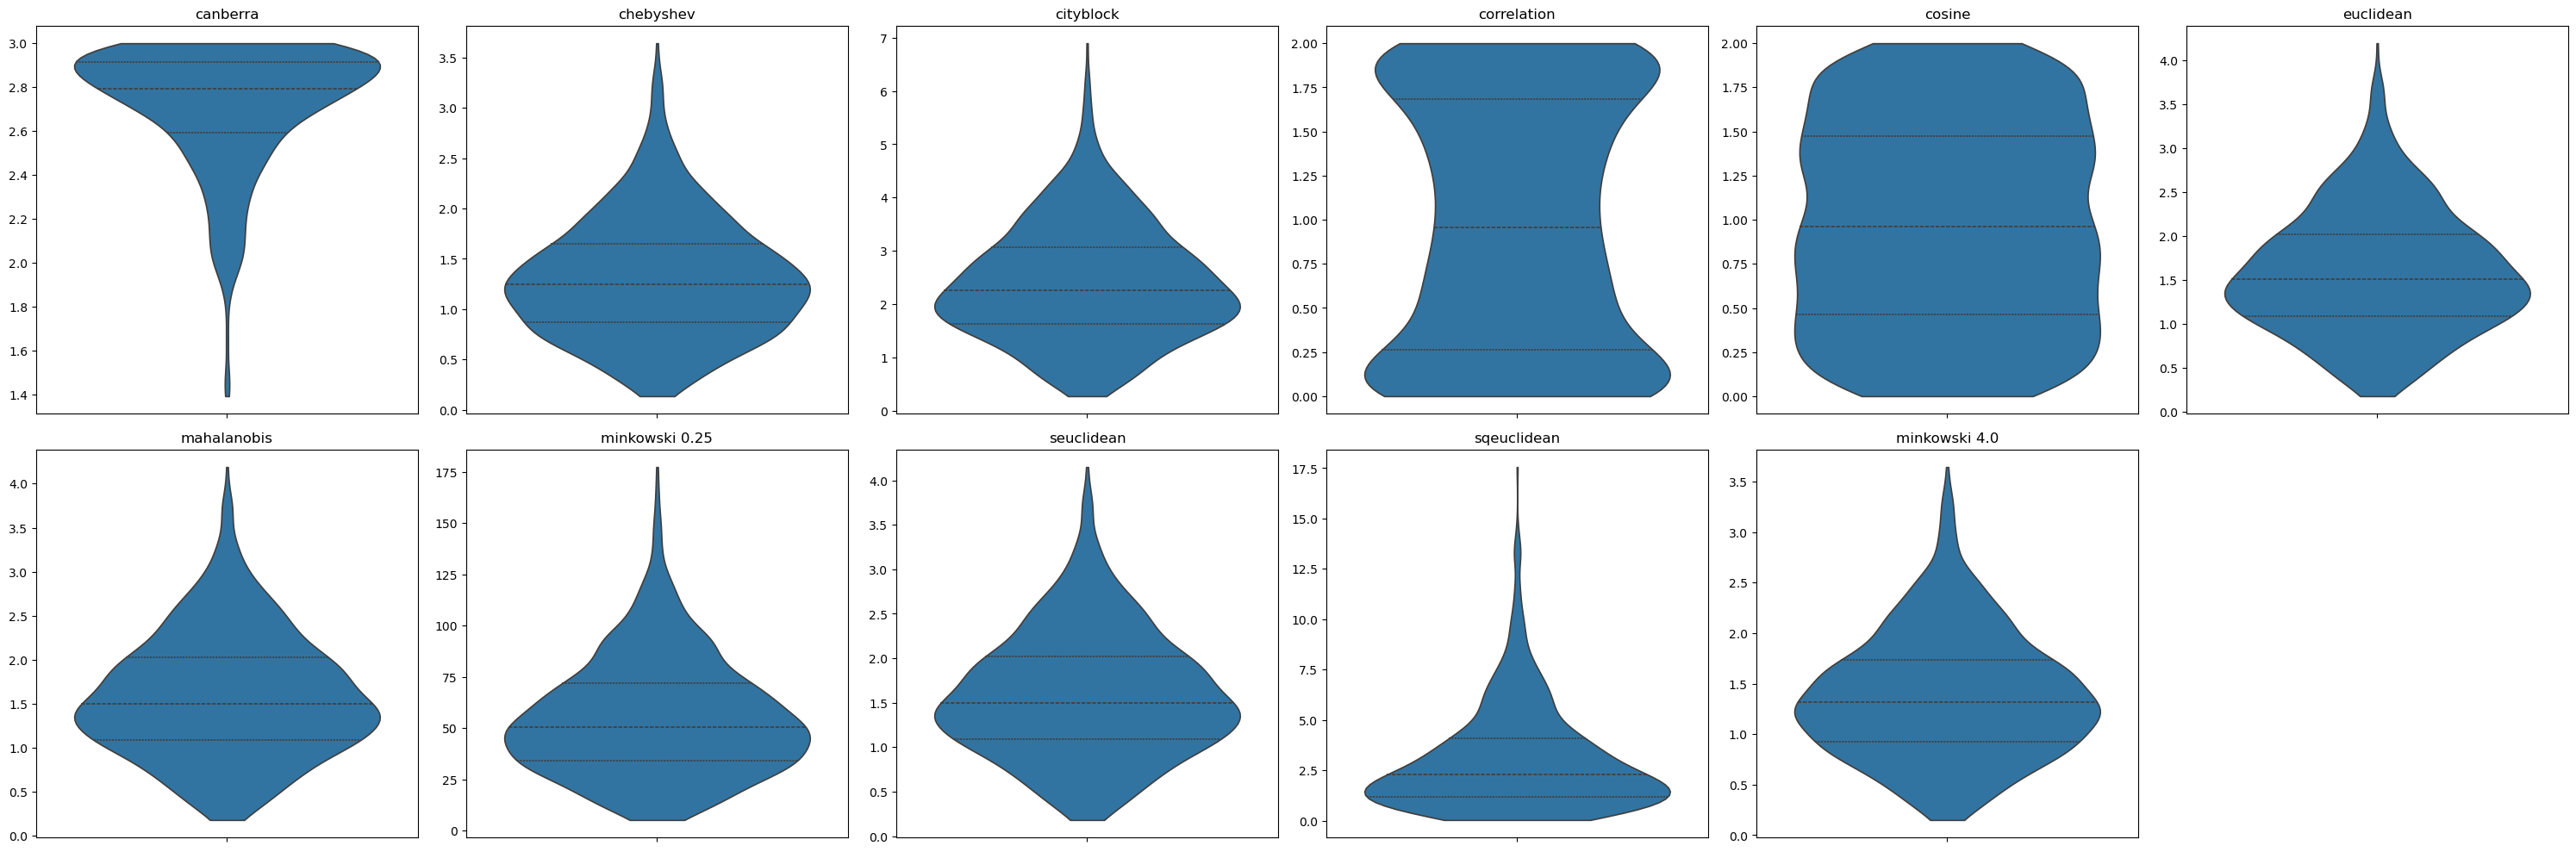

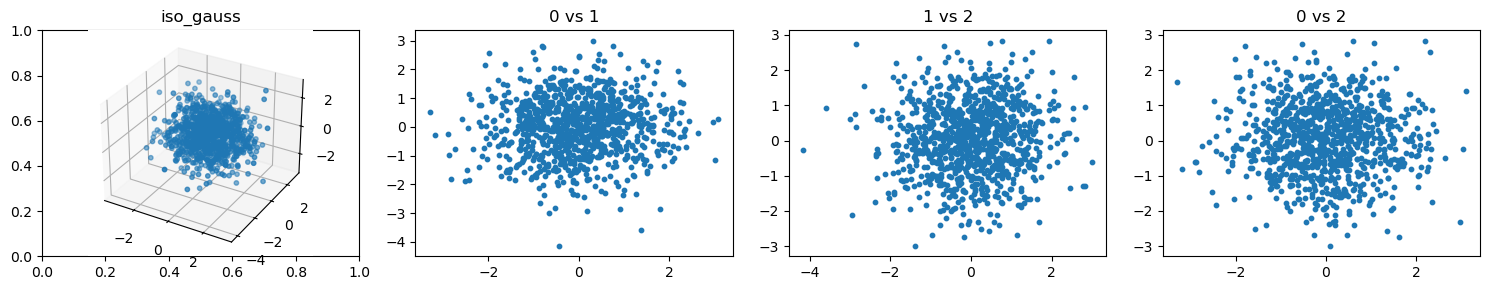

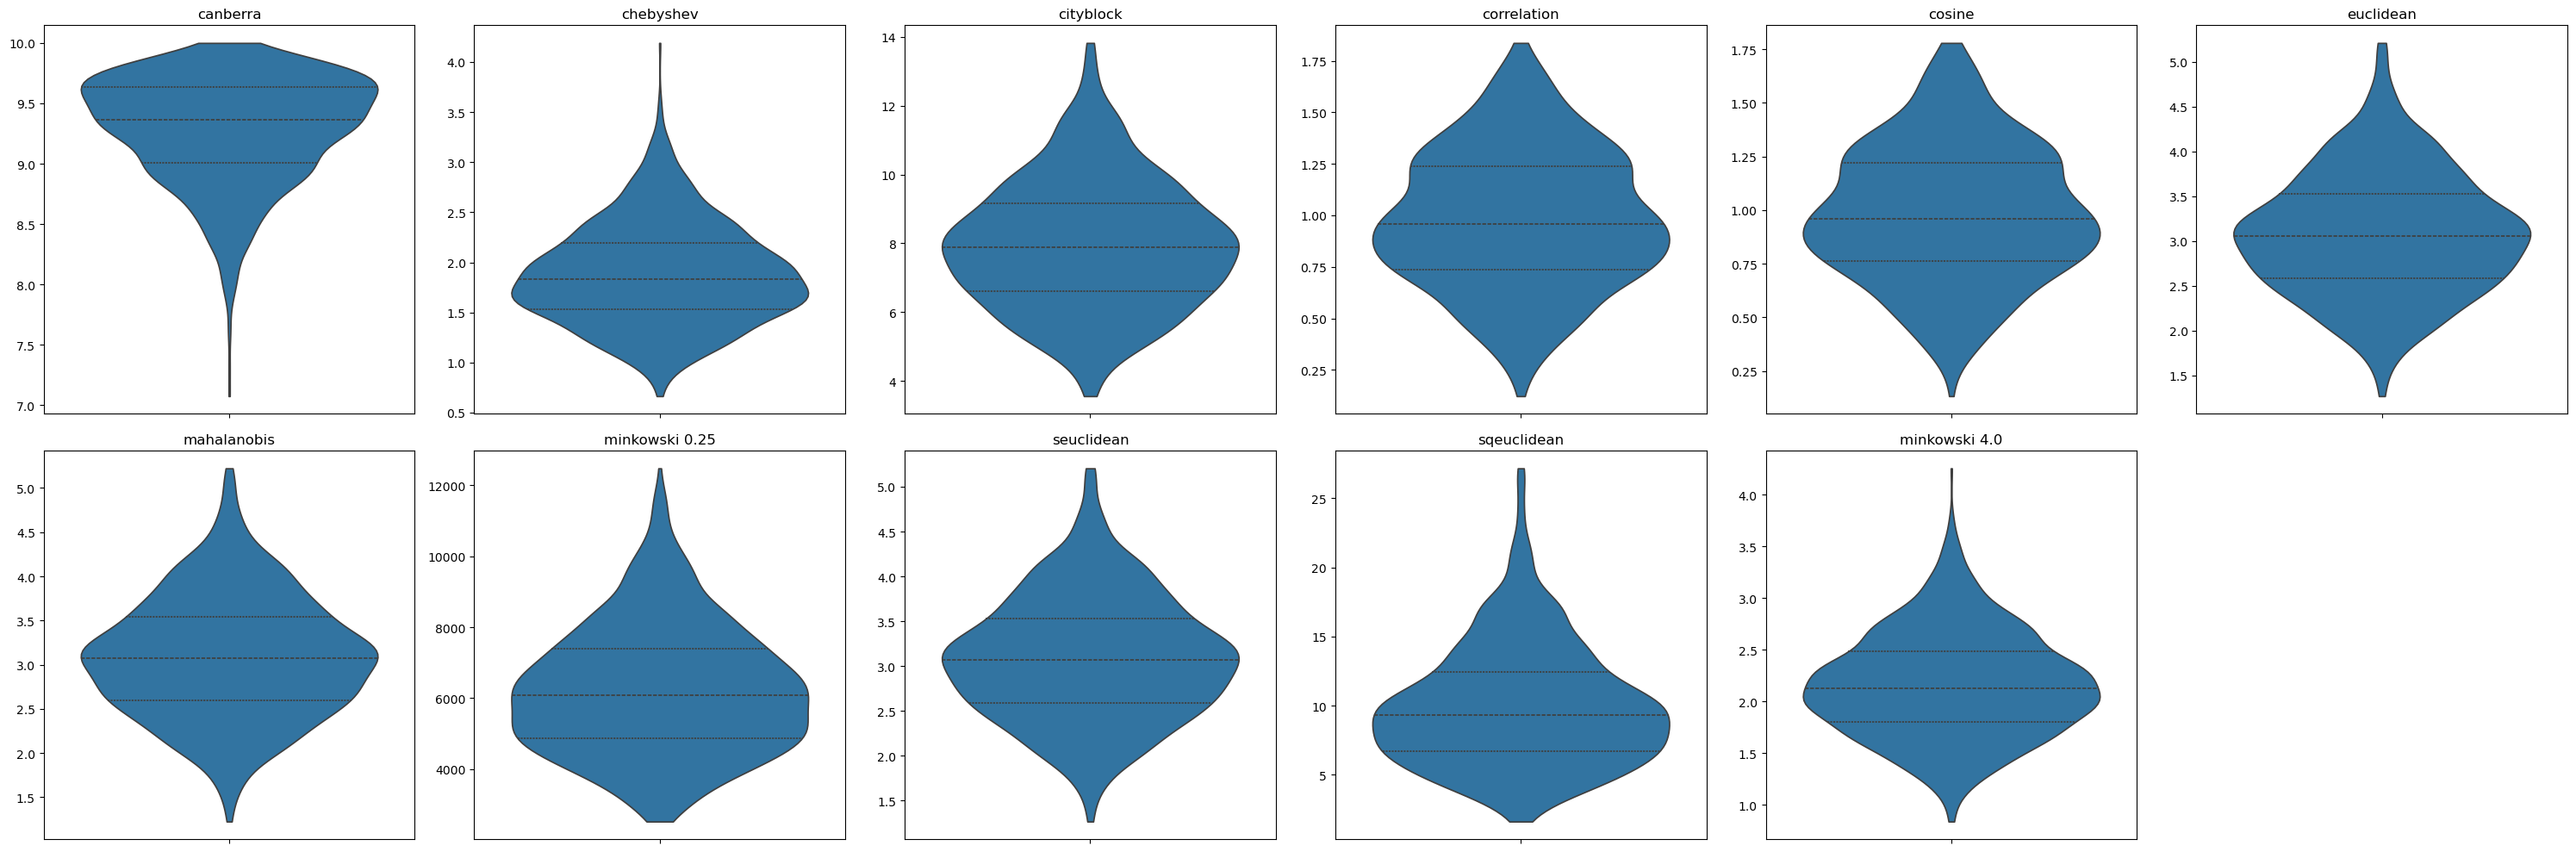

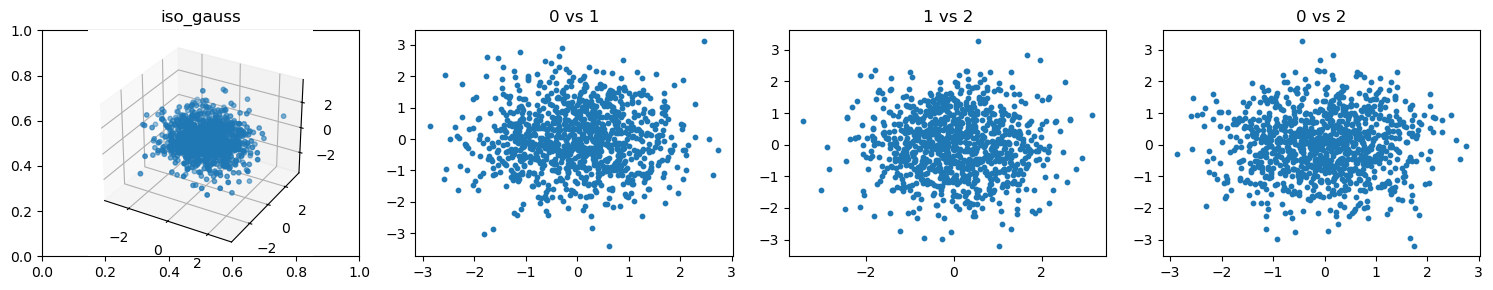

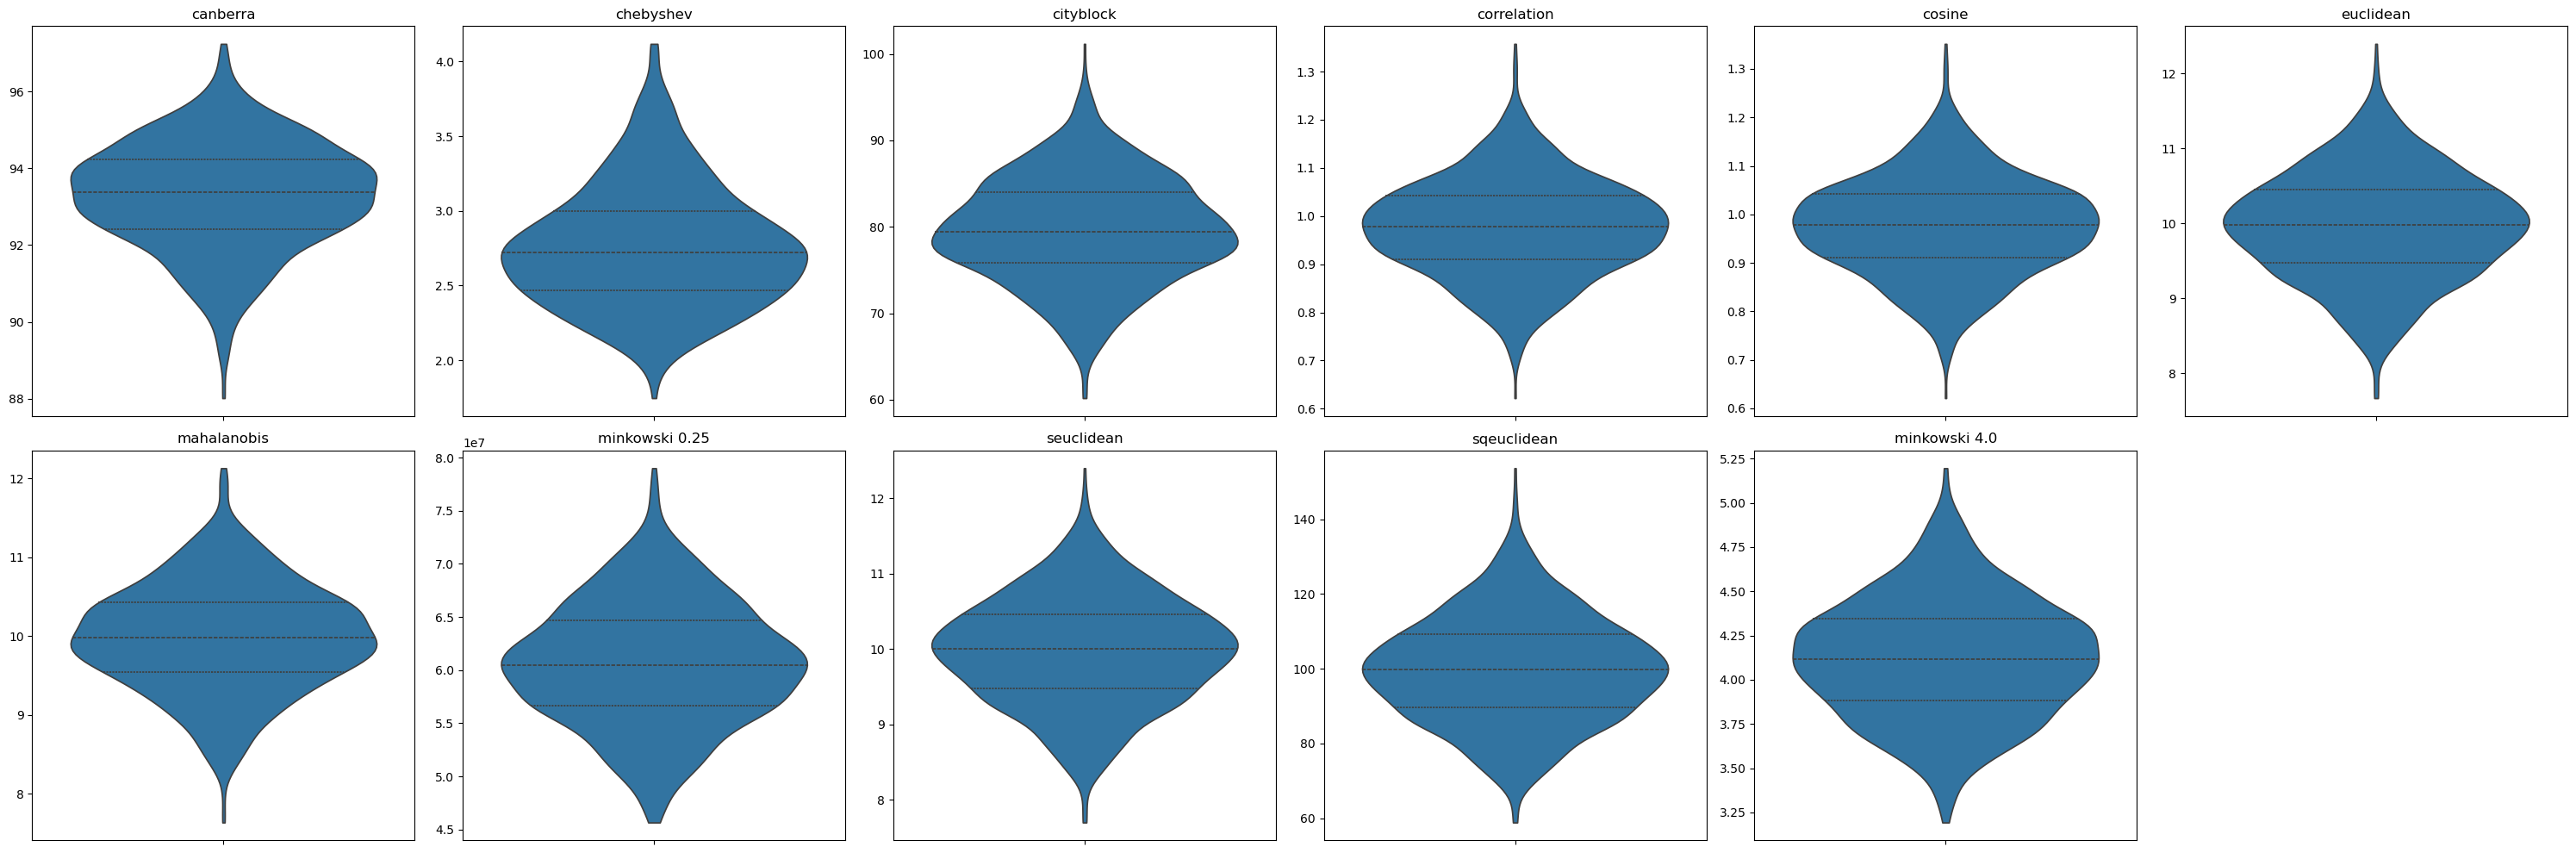

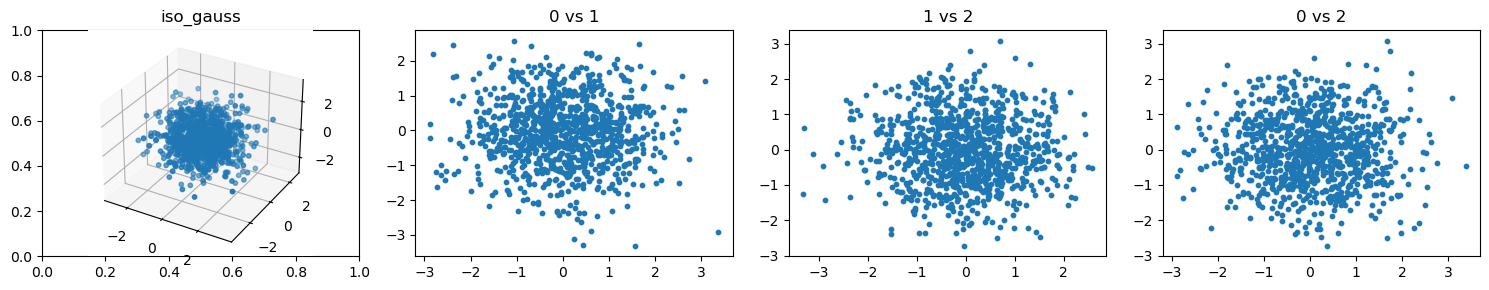

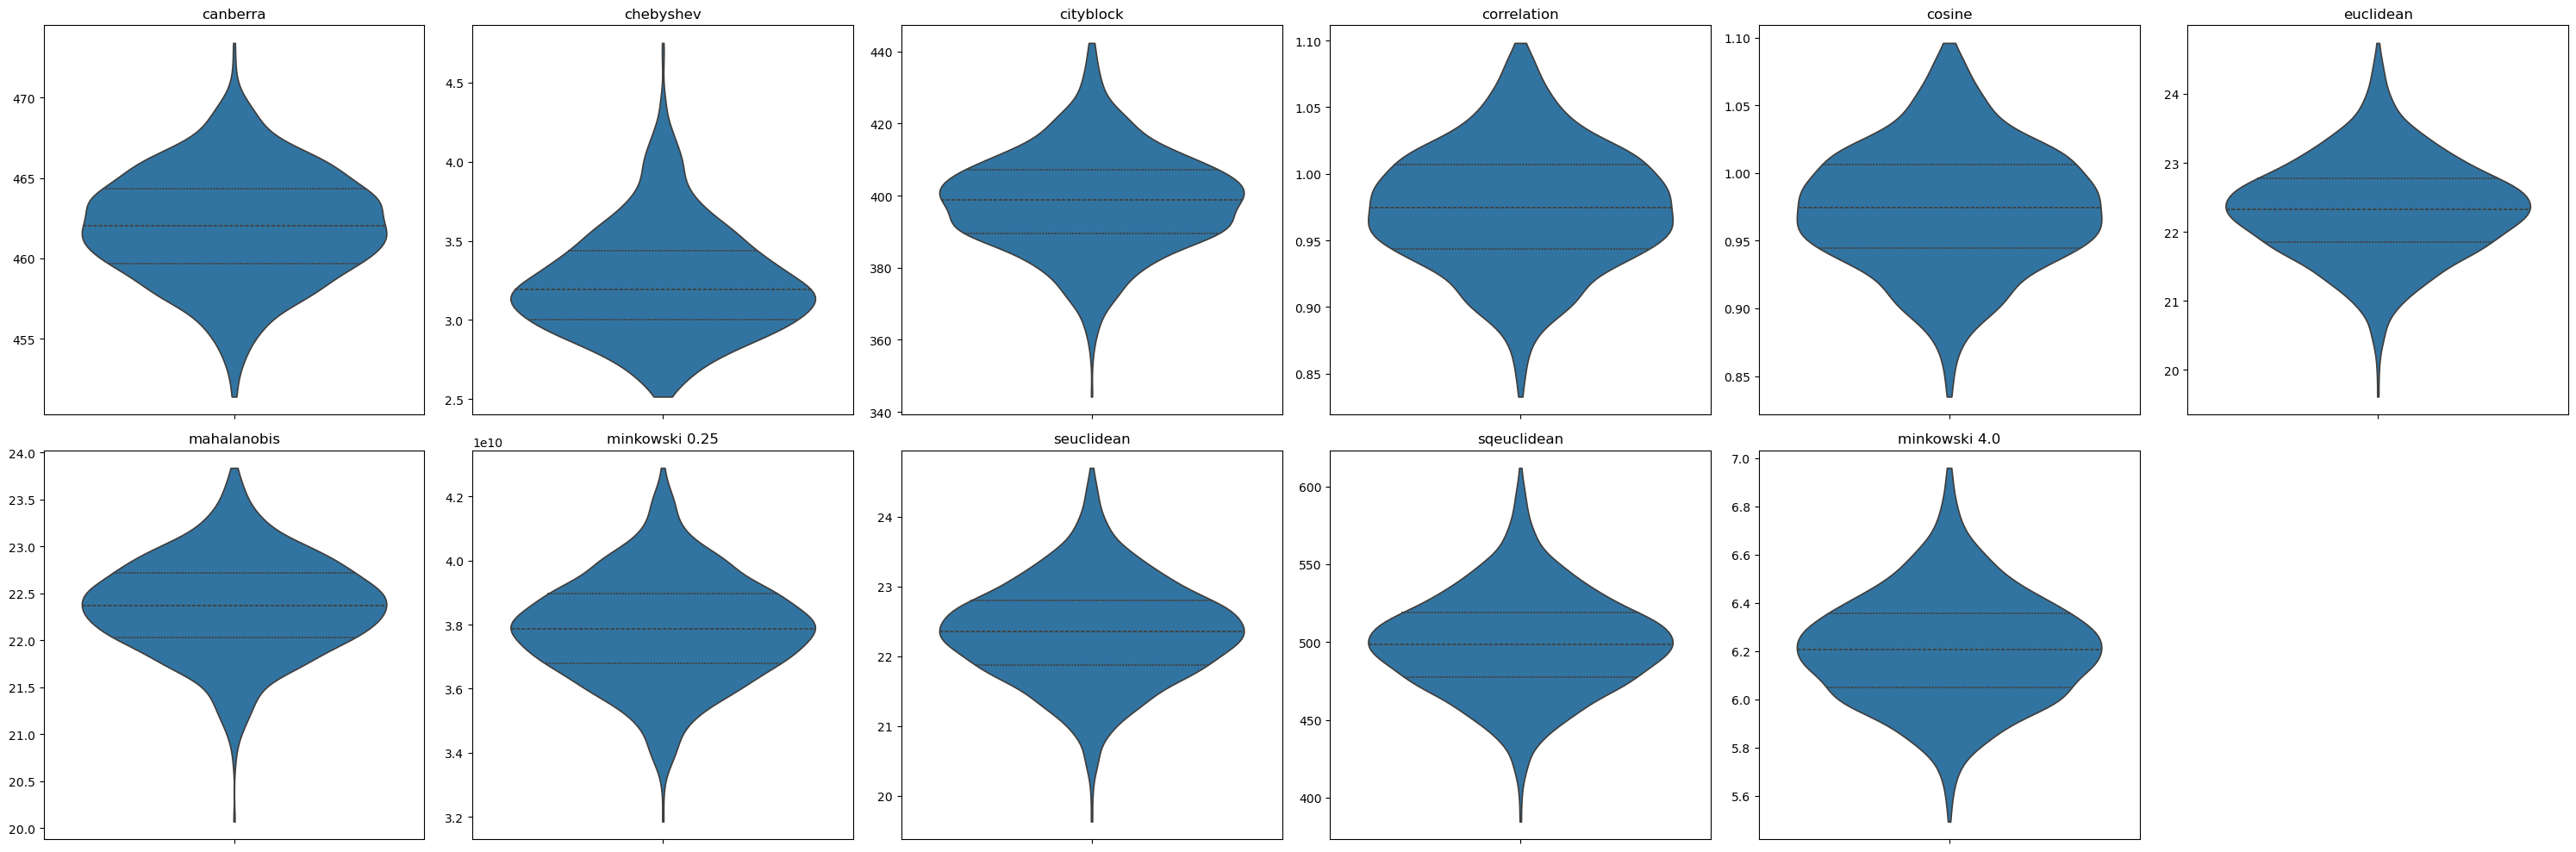

In [44]:
for n_features in [3,10,100,500]:
    X = isotropic_gaussian(n_samples, n_features)
    plot_3d_scatters(X,'iso_gauss')
    plot_dist_distribution(X,point='global_median_centroid',dist_scale='none')

(1000, 3)


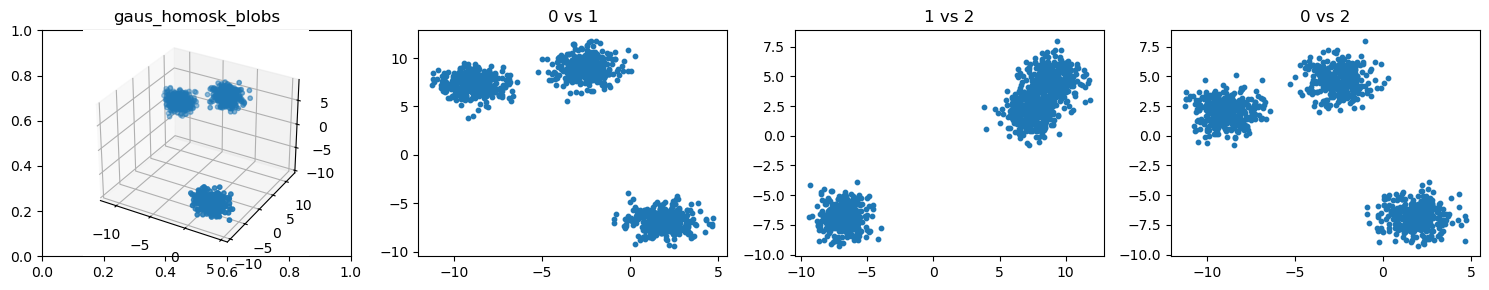

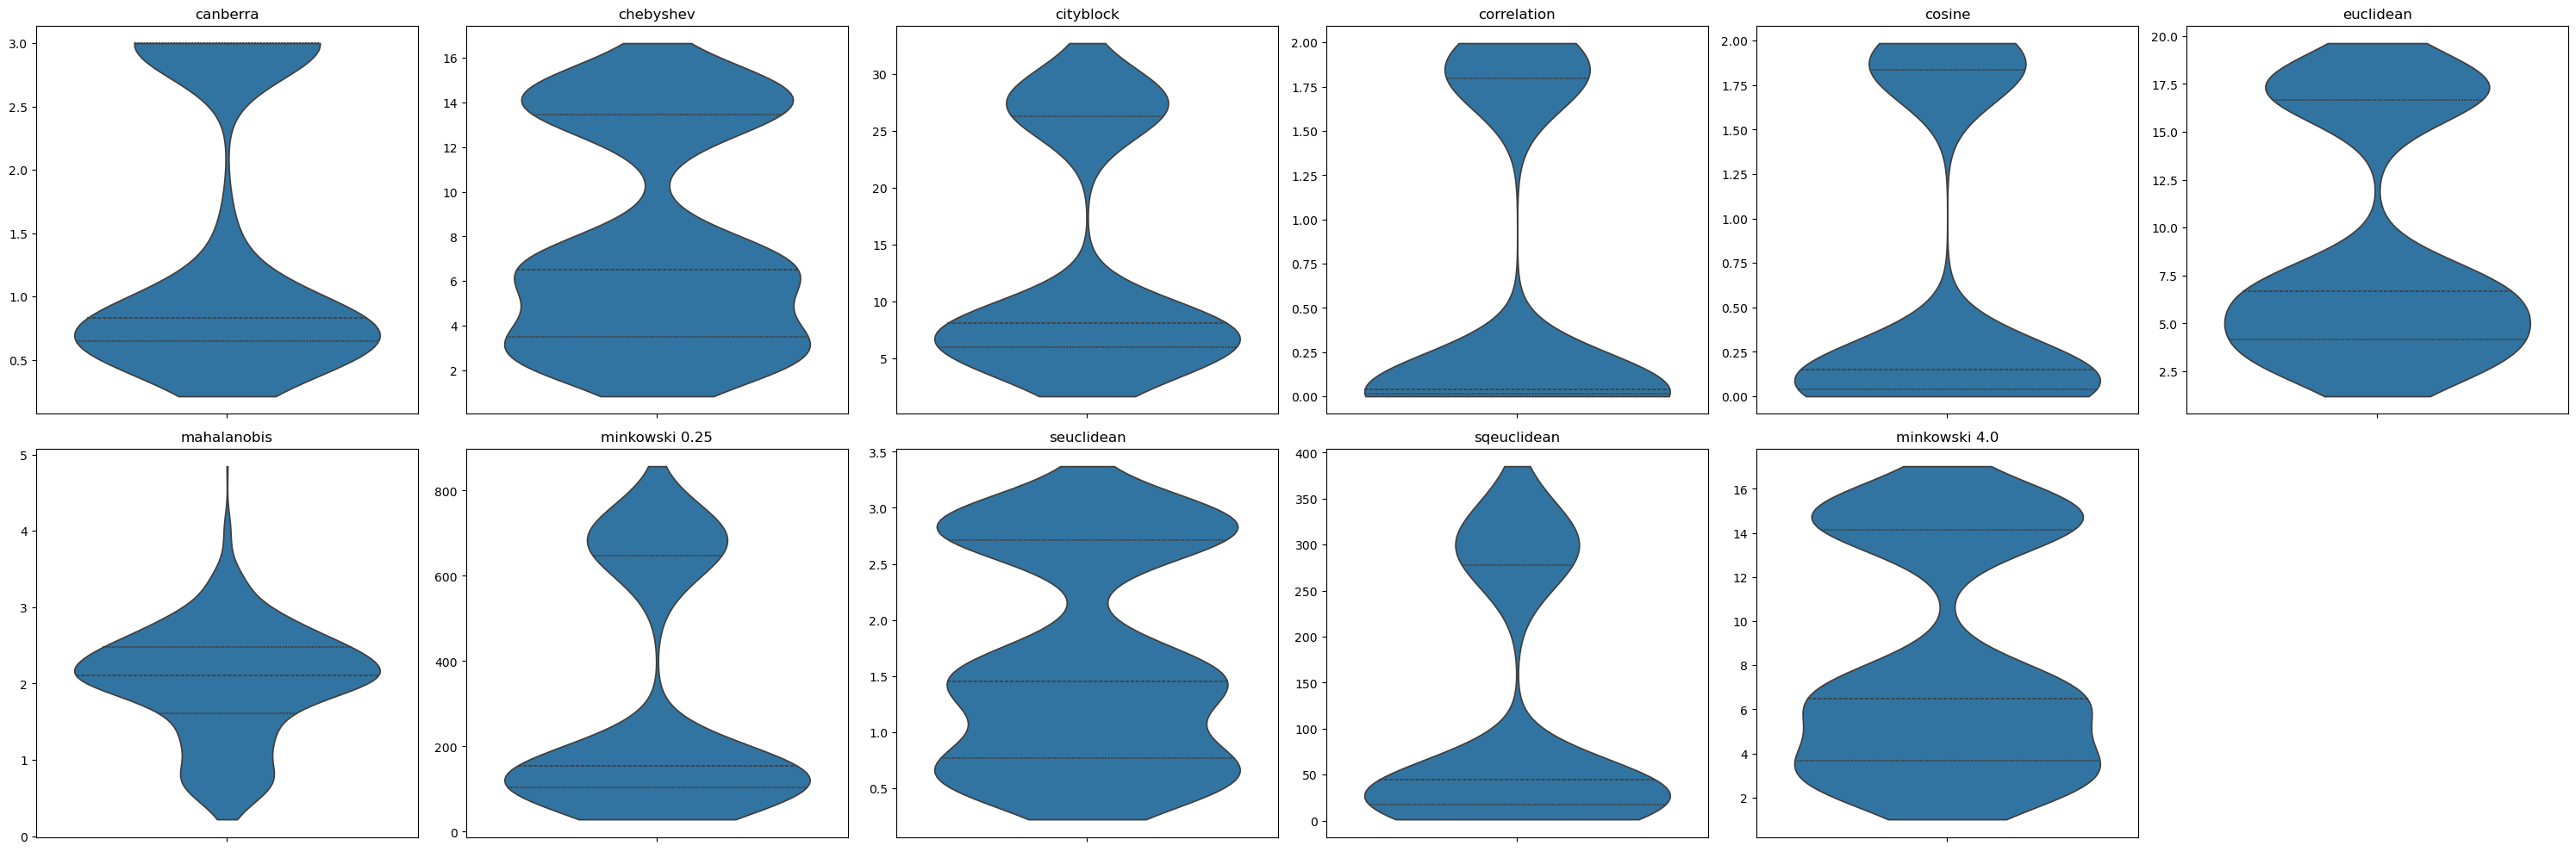

(1000, 10)


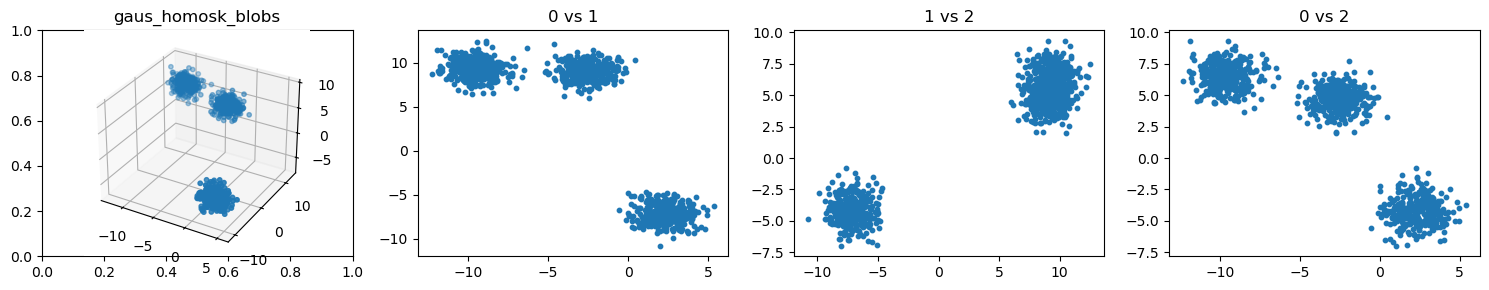

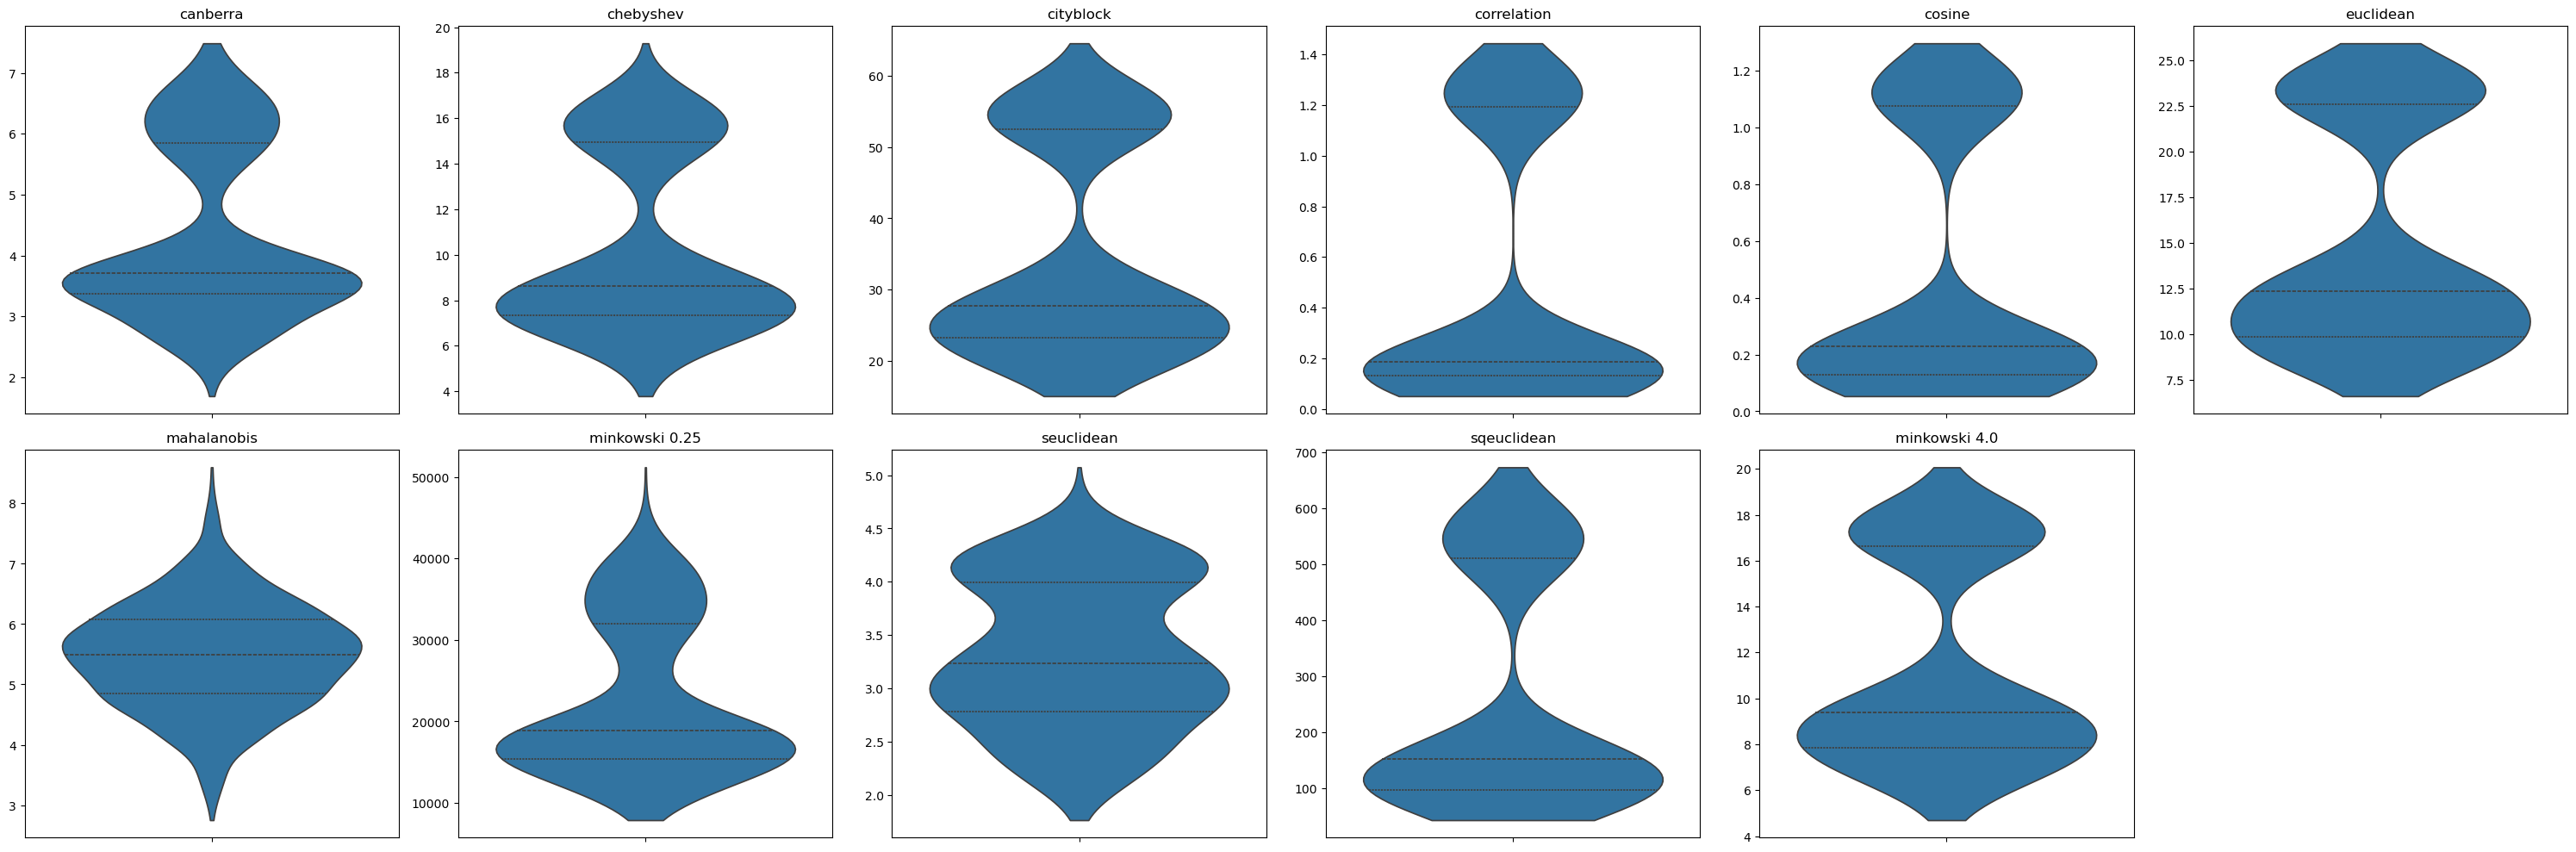

(1000, 100)


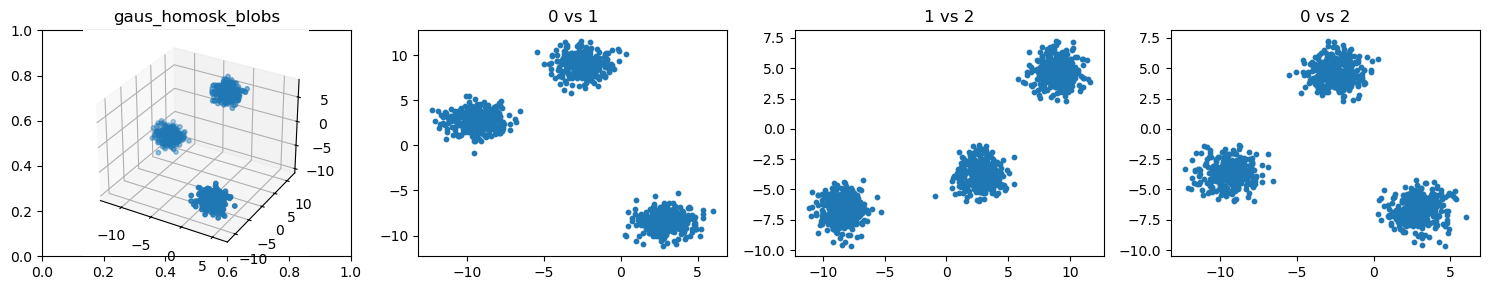

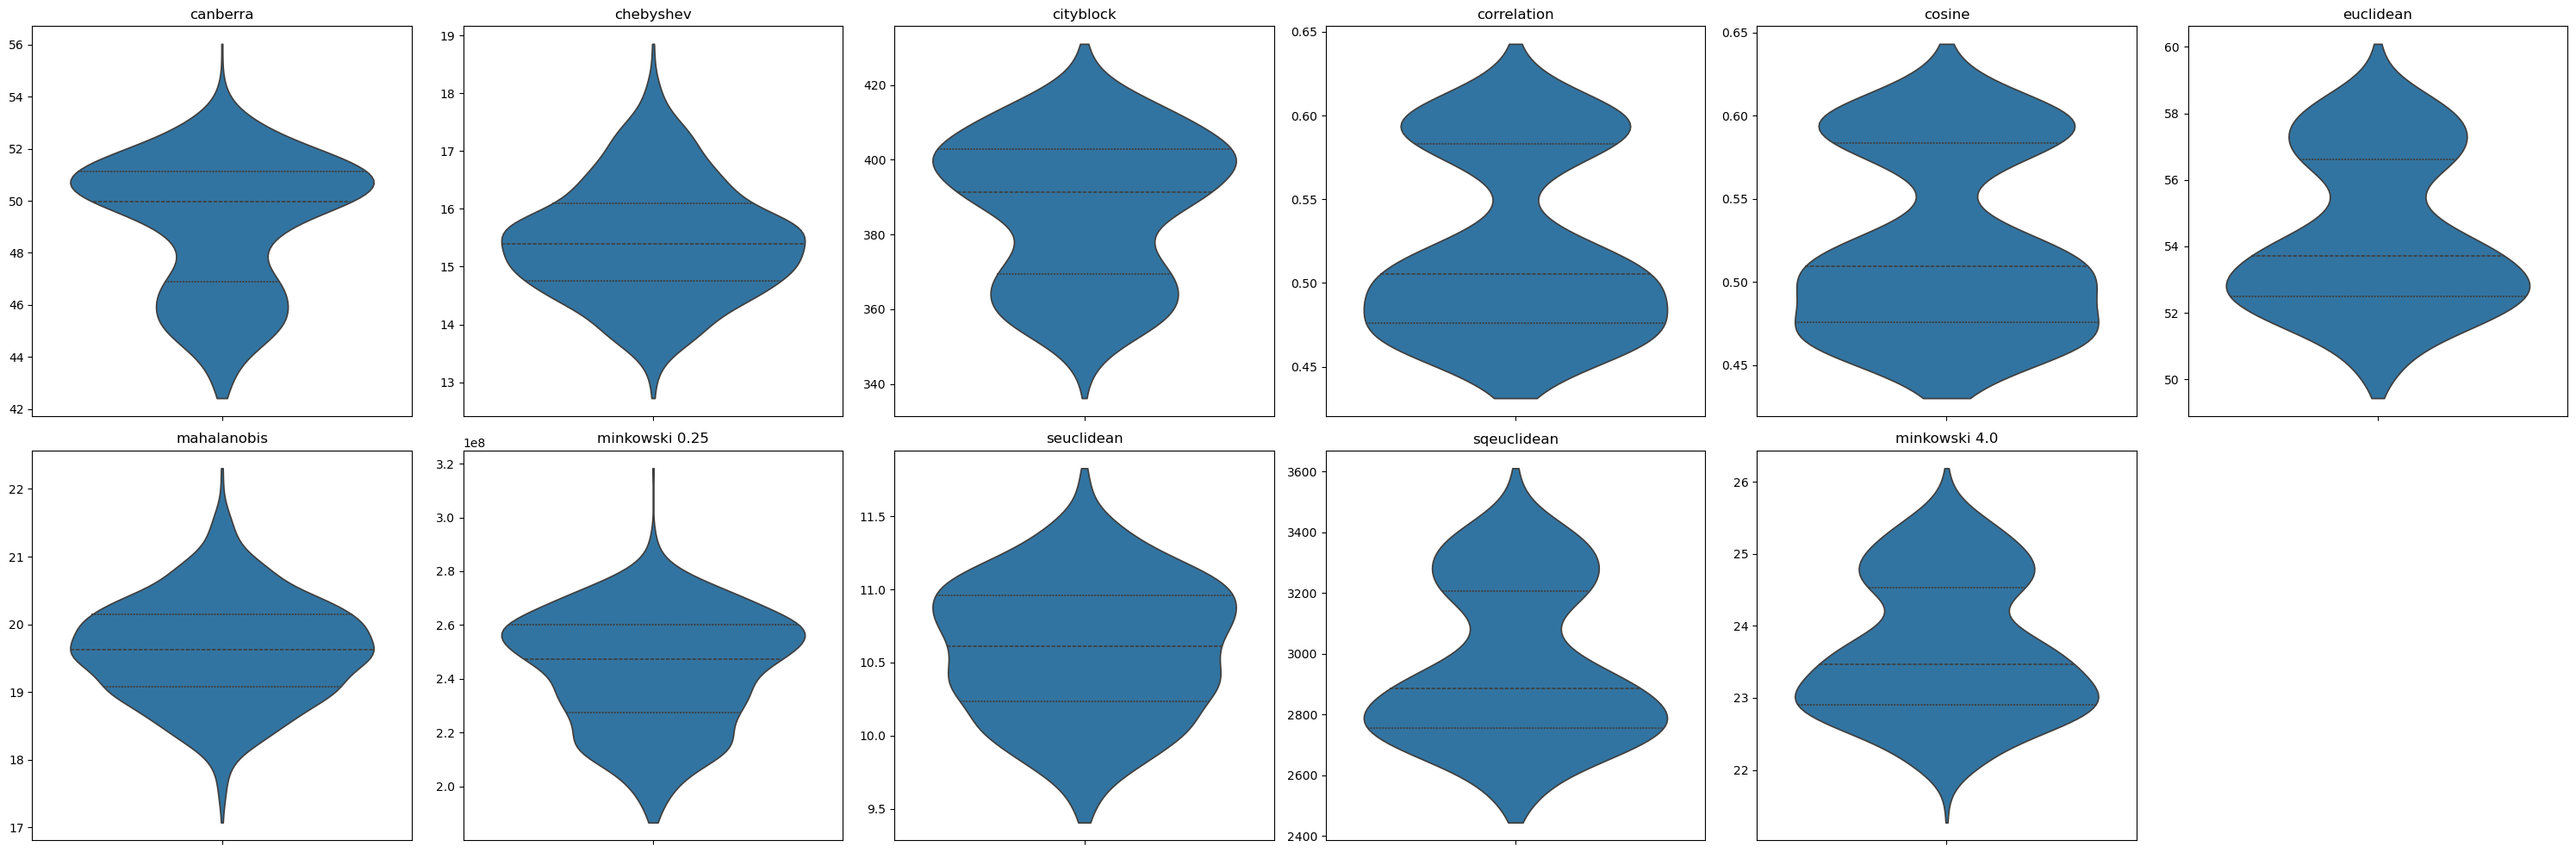

(1000, 500)


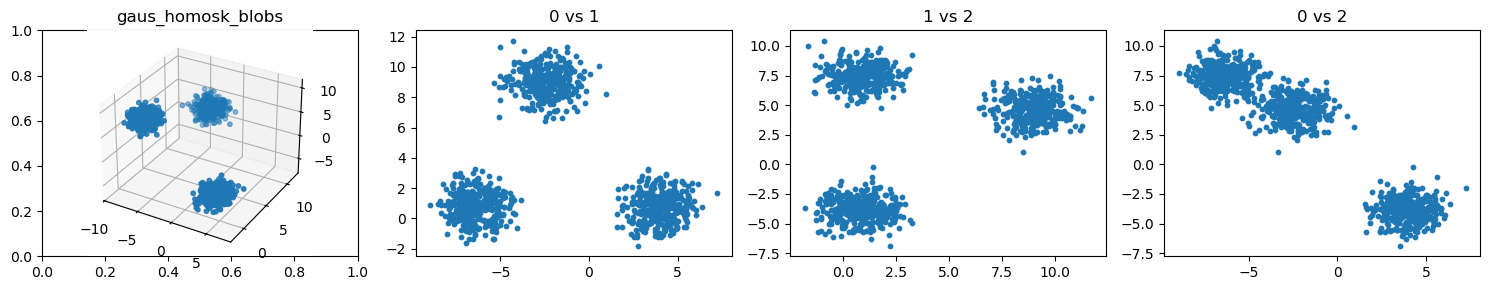

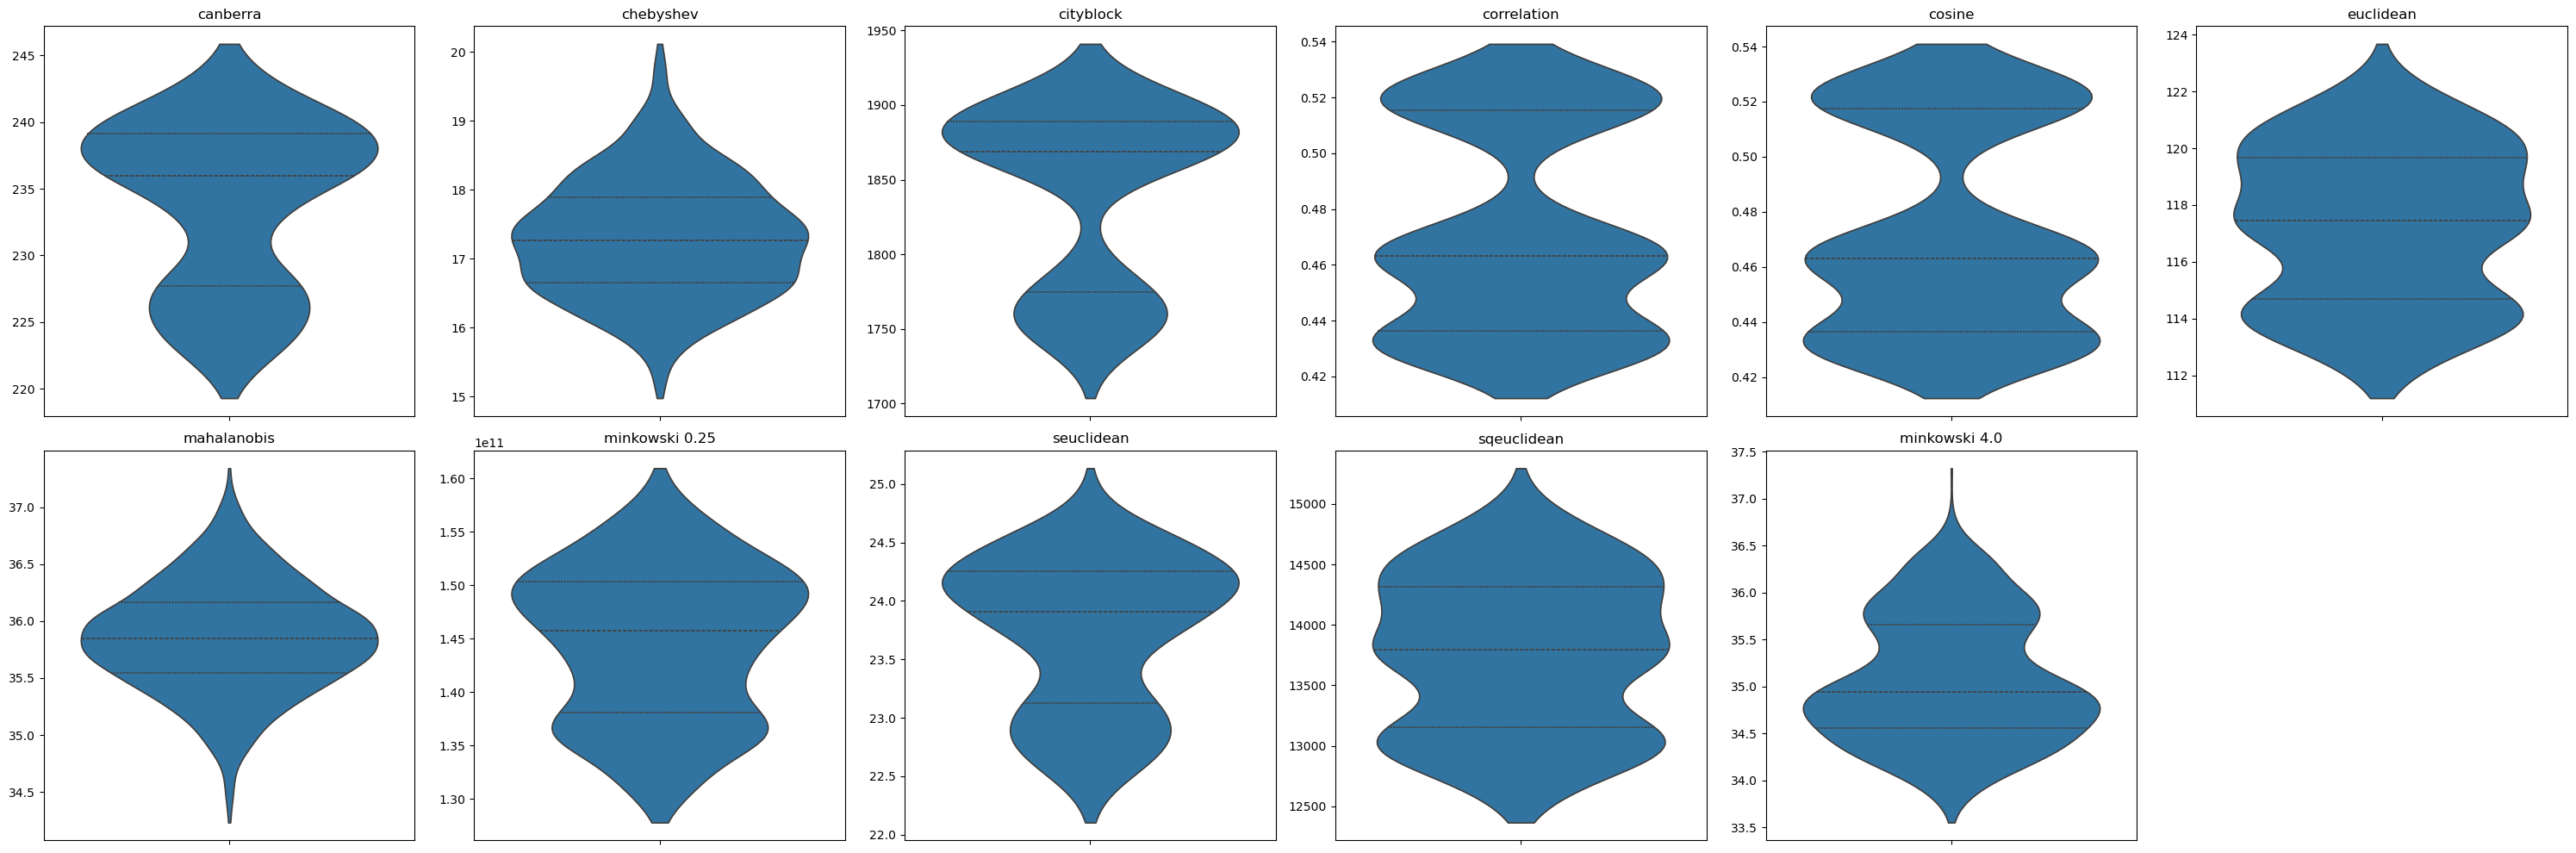

In [45]:
for n_features in [3,10,100,500]:
    # X = isotropic_gaussian(n_samples, n_features)

    gaus_homosk_blobs = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed)
    X = gaus_homosk_blobs[0]
    print(X.shape)
    
    plot_3d_scatters(X,'gaus_homosk_blobs')
    plot_dist_distribution(X,point='global_median_centroid',dist_scale='none')

(1000, 3)


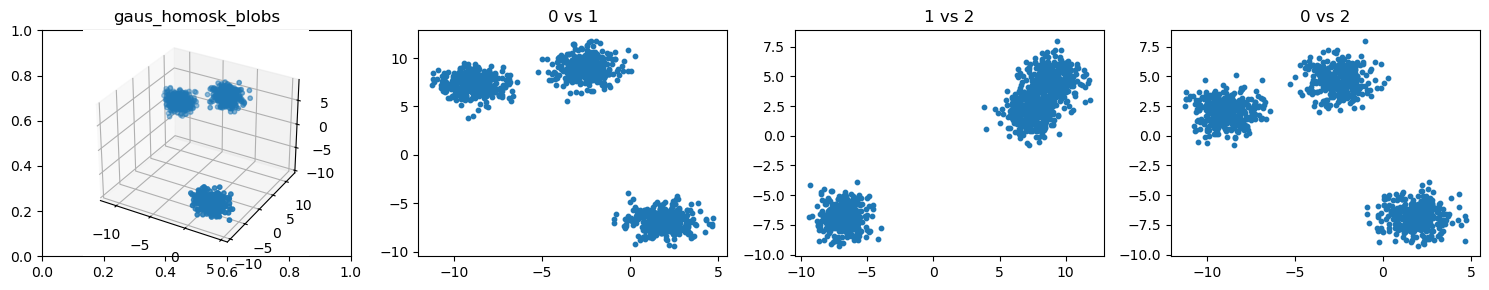

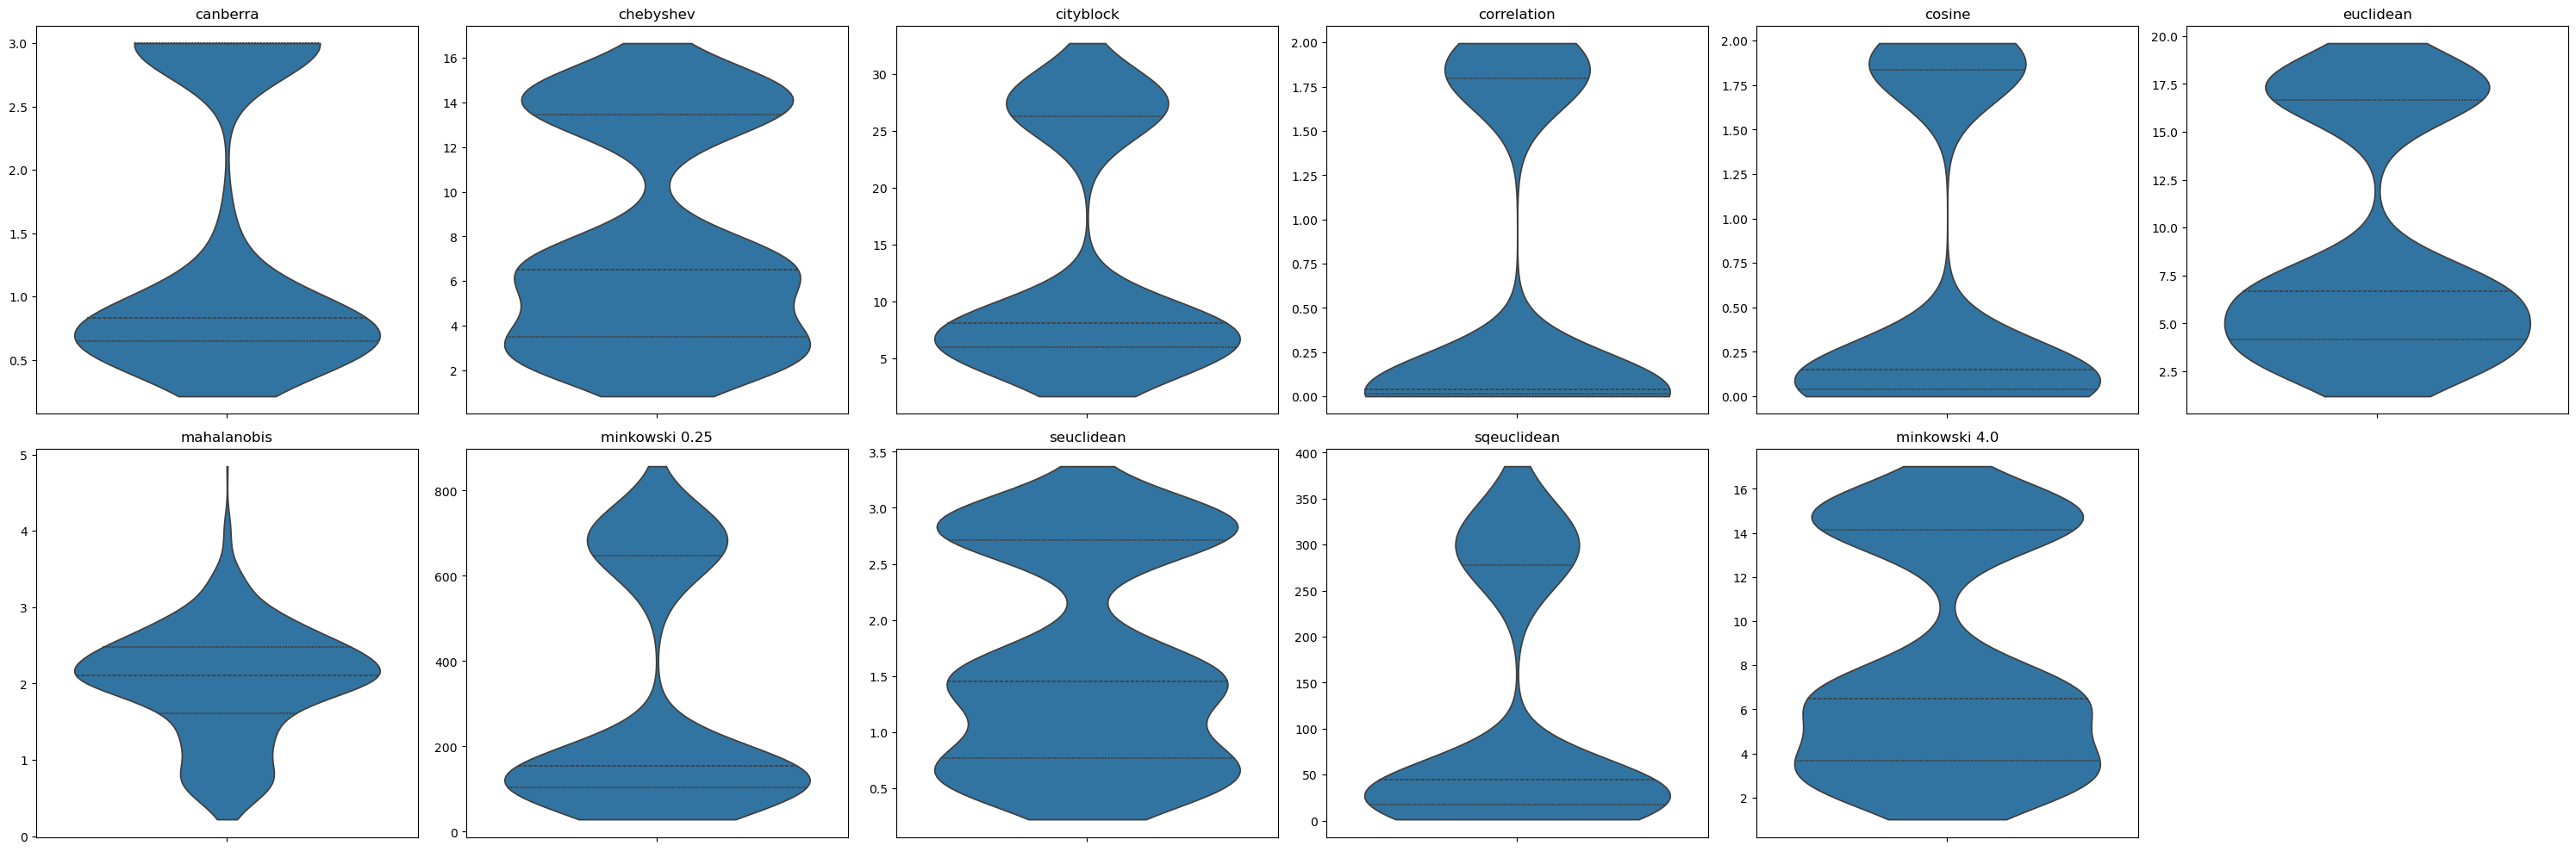

In [46]:
# for n_features in [3,10,100,500]:
    # X = isotropic_gaussian(n_samples, n_features)

gaus_homosk_blobs = datasets.make_blobs(n_samples=1000,n_features=3, random_state=seed)
X = gaus_homosk_blobs[0]
print(X.shape)

plot_3d_scatters(X,'gaus_homosk_blobs')
plot_dist_distribution(X,point='global_median_centroid',dist_scale='none')

In [52]:
# dist_from_center

In [ ]:
# from scipy.stats import gaussian_kde
# from scipy.signal import find_peaks

# dist_from_center = dist_from_point(X,point='global_mean_centroid',metric='correlation')        
# dist_from_center = dist_from_center.flatten()
# kde = gaussian_kde(dist_from_center, bw_method='silverman')
# xs = np.linspace(min(dist_from_center), max(dist_from_center), 1000)
# ys = kde(xs)
# peaks, _ = find_peaks(ys)
# n_modes = len(peaks)
# plt.scatter(x=xs,y=ys)

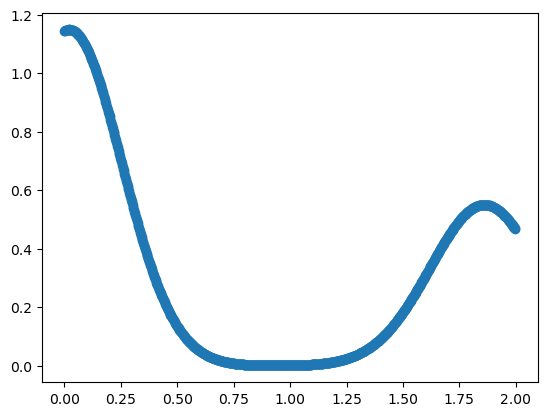

In [28]:
# plot_dict = plot_dist_distribution(gaus_homosk_blobs[0],point='global_median_centroid',dist_scale='iqr')
# plot_violin_dist_facets(plot_dict)

In [29]:
# plot_dist_distribution(gaus_heterosk_blobs[0],point='global_median_centroid',dist_scale='iqr')

In [30]:
def plot_kernel_distribution(X,point=None):

    kernel_fns_lst = list(sklearn_pairwise.kernel_metrics().keys())
    exclude_kernel_lst = ['additive_chi2','chi2']
    
    kernel_fns_lst = [v for v in kernel_fns_lst if v not in exclude_kernel_lst]

    nr = 2
    nc = 4
    fig, axes = plt.subplots(2, 4, figsize=(5*nc, 5*nr)) 
    axes = axes.flatten()  # Flatten to 1D array for easy indexing

    for i,kernel_fn_str in enumerate(kernel_fns_lst):

        kernel_from_pt = kernel_from_point(X,point=point,kernel_fn=kernel_fn_str)

        try:
            ax = axes[i]
            ax.hist(kernel_from_pt)

        except:
            print(f'{kernel_fn_str} failed')

        ax.set_title(kernel_fn_str)        
    
    plt.show()


In [31]:
# plot_kernel_distribution(X,point='global_mean_centroid')

In [32]:
# plot_kernel_distribution(gaus_homosk_blobs[0],point='global_mean_centroid')

In [33]:
# plot_kernel_distribution(gaus_heterosk_blobs[0],point='global_mean_centroid')

In [34]:
# plot_dist_distribution(gaus_heterosk_blobs[0],point='global_mean_centroid')

## plotting functions of distance

In [35]:
def plot_kernel_fn_vs_dist(X,point=None,metric='euclidean'):

    fig, axes = plt.subplots(2, 4, figsize=(15, 12))  # 3x3 grid
    axes = axes.flatten()  # Flatten to 1D array for easy indexing

    kernel_fns_lst = list(sklearn_pairwise.kernel_metrics().keys())
    exclude_kernel_lst = ['additive_chi2','chi2']
    
    kernel_fns_lst = [v for v in kernel_fns_lst if v not in exclude_kernel_lst]

    for i,kernel_fn_str in enumerate(kernel_fns_lst):
        # print(kernel_fn_str)
        dist_from_center = dist_from_point(X,point=point,metric=metric)
        dist_from_center_norm_rad = dist_from_center
        # /np.max(dist_from_center)

        kernel_from_pt = kernel_from_point(X,point=point,kernel_fn=kernel_fn_str)

        ax = axes[i]
        ax.scatter(x=dist_from_center_norm_rad, y=kernel_from_pt)
        ax.set_title(kernel_fn_str)
        ax.set_xlabel(metric)
        # ax.set_ylabel("Kernel Value")
    
    plt.show()

In [36]:
def plot_fn_vs_dist(X,point=None,metric='euclidean'):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    axes = axes.flatten()  # Flatten to 1D array for easy indexing

    fns_lst = {}
    const_decay = 1
    fns_lst['exp_decay_dist'] = lambda distvect : np.exp(-distvect*const_decay)
    fns_lst['inv_scaled_dist'] = lambda distvect : 1 / (distvect / np.max(distvect))

    for i,fn_str in enumerate(fns_lst.keys()):

        dist_from_center = dist_from_point(X,point=point,metric=metric)
        scaled_dist_from_center = dist_from_center / np.max(dist_from_center)
        
        fn_dist_from_center = fns_lst[fn_str](scaled_dist_from_center)

        ax = axes[i]
        ax.scatter(x=scaled_dist_from_center, y=fn_dist_from_center)
        ax.set_title(fn_str)
        ax.set_xlabel(metric)
        # ax.set_ylabel("Kernel Value")
    
    plt.show()

In [37]:
# for metric_val in lst_metrics:
    # plot_kernel_fn_vs_dist(X,metric=metric_val)
    # plot_dist_distrib(X,metric=metric_val)
    # plot_fn_vs_dist(gaus_heterosk_blobs[0],metric=metric_val)
    

In [38]:
# plot_fn_vs_dist(gaus_homosk_blobs[0],metric='euclidean')

In [39]:
# plot_fn_vs_dist(gaus_heterosk_blobs[0],metric='euclidean')

In [40]:
# plot_kernel_fn_vs_dist(gaus_heterosk_blobs[0],metric='euclidean')

In [41]:
# plot_kernel_fn_vs_dist(gaus_homosk_blobs[0],metric='euclidean')

In [42]:
# plot_kernel_fn_vs_dist(X,metric='euclidean')